# Denosing AE (잡음 제거 오토인코더)

정의: Denoising AE는 입력 데이터에 고의적으로 잡음을 추가한 후, 원래의 깨끗한 데이터를 복원하는 방식으로 학습합니다. <br>
특징: 잡음에 강한 특징을 학습하며, 데이터의 잡음을 제거하는 데 유용합니다. 일반적으로 데이터의 노이즈를 줄이는 데 효과적입니다.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

In [6]:
df = pd.read_csv("../dataset/DSA_features.csv")
df

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting,p1
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting,p1
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting,p1
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting,p1
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting,p1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9115,8.280854,34.1980,-2.9038,28.080803,5.299132,1.350075,-1.491537,11.2240,-11.65100,14.670334,...,0.200829,-0.040701,0.297666,0.708480,-0.117430,4.135451e-02,0.203358,-0.310022,basketBall,p8
9116,9.591118,51.6970,-3.4129,35.722025,5.976791,2.981144,0.086304,6.9951,-11.76400,5.329897,...,0.148745,-0.266377,0.224716,0.554670,-0.250950,3.355704e-02,0.183186,-0.736410,basketBall,p8
9117,9.599113,27.9300,-1.0765,48.850886,6.989341,0.449237,-0.728367,3.7801,-8.36910,5.683022,...,0.310748,-0.009505,-0.237786,0.088854,-0.477260,2.026107e-02,0.142341,0.668438,basketBall,p8
9118,9.692482,72.7820,-2.6734,59.378336,7.705734,4.491114,-0.582724,6.1216,-8.85710,4.162963,...,0.156493,0.050624,0.533023,0.677800,0.055941,1.356379e-02,0.116464,-1.482489,basketBall,p8


In [8]:
df.isnull().values.any()

False

In [10]:
uniques = df['activity'].unique()
uniques

array(['sitting', 'standing', 'lyingBack', 'lyingRigh', 'ascendingStairs',
       'decendingStairs', 'standingInElevatorStill', 'movingInElevator',
       'walkingLot', 'walkingTreadmillFlat', 'walkingTreadmillIncline',
       'runningTreadmill', 'stepper', 'crossTrainer', 'cyclingHorizontal',
       'cyclingVertical', 'rowing', 'jumping', 'basketBall'], dtype=object)

In [12]:
# lyingRigh 480, lyingBack 480 : 정상데이터
# jumping(abnormal) : 비정상 데이터로 

In [14]:
df_filtered = df[df['activity'].isin(['lyingRigh','lyingBack','jumping'])]
activity_counts = df_filtered['activity'].value_counts()

print(activity_counts)
df_filtered

activity
lyingBack    480
lyingRigh    480
jumping      480
Name: count, dtype: int64


,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
960,-4.834646,-4.7185,-4.9049,0.001124,0.033529,0.632141,-0.501018,-0.41744,-0.59561,0.001016,...,0.000986,0.074676,-0.532664,-0.52993,-0.53521,9.585668e-07,0.000979,-0.193301,lyingBack,p1
961,-4.780810,-4.5850,-4.8833,0.003948,0.062835,1.052880,-0.480601,-0.40372,-0.63184,0.001297,...,0.000788,-0.181526,-0.531169,-0.52940,-0.53365,7.608973e-07,0.000872,-0.372381,lyingBack,p1
962,-4.804400,-4.7037,-4.8755,0.001482,0.038496,0.735226,-0.493925,-0.42616,-0.59561,0.000863,...,0.000677,-0.263115,-0.530569,-0.52873,-0.53222,5.160537e-07,0.000718,0.185587,lyingBack,p1
963,-4.750563,-4.5696,-4.8977,0.004447,0.066683,0.710263,-0.437358,-0.30877,-0.55225,0.003587,...,0.000686,-0.060925,-0.531167,-0.52962,-0.53283,4.975523e-07,0.000705,-0.145321,lyingBack,p1
964,-4.774916,-4.6741,-4.8457,0.001080,0.032868,0.324779,-0.459456,-0.38900,-0.53714,0.001059,...,0.000739,0.335811,-0.529804,-0.52706,-0.53251,1.292131e-06,0.001137,-0.026271,lyingBack,p1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8635,9.298029,32.4980,-6.0782,134.634624,11.603216,0.570723,-2.592341,1.73230,-12.91800,9.207424,...,0.030501,0.334449,0.625187,0.69130,0.57187,9.188517e-04,0.030313,0.274486,jumping,p8
8636,8.738784,34.0480,-6.7822,145.225186,12.050941,0.760224,-2.417799,1.19030,-10.90200,9.233904,...,0.031573,0.396417,0.624749,0.69356,0.57040,9.632708e-04,0.031037,0.433661,jumping,p8
8637,9.404261,34.8670,-5.3331,130.142955,11.408022,0.560963,-2.408945,0.81347,-8.21750,6.635468,...,0.030322,0.524964,0.631822,0.69012,0.58197,8.933477e-04,0.029889,0.335023,jumping,p8
8638,9.139112,32.5060,-6.8835,135.812815,11.653876,0.589304,-2.359531,1.32350,-9.57930,7.510565,...,0.024060,0.301200,0.624196,0.68856,0.57362,1.025797e-03,0.032028,0.272121,jumping,p8


In [16]:
df_filtered.shape

(1440, 272)

In [18]:
abnormal = df[df.activity == 'jumping']
normal = df[df.activity.isin(['lyingRigh', 'lyingBack'])]

# 정상 데이터에 Class 열 추가
normal['Class'] = 0 

# 비정상 데이터에 Class 열 추가
abnormal['Class'] = 1  

# 두 데이터프레임을 합쳐서 최종 데이터프레임 생성
df_final = pd.concat([normal, abnormal], ignore_index=True)

df_final

/var/folders/nr/9d9y7mfn50b3sc_ncv28vstc0000gn/T/ipykernel_31692/1296092208.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal['Class'] = 0
/var/folders/nr/9d9y7mfn50b3sc_ncv28vstc0000gn/T/ipykernel_31692/1296092208.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abnormal['Class'] = 1


,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people,Class
0,-4.834646,-4.7185,-4.9049,0.001124,0.033529,0.632141,-0.501018,-0.41744,-0.59561,0.001016,...,0.074676,-0.532664,-0.52993,-0.53521,9.585668e-07,0.000979,-0.193301,lyingBack,p1,0
1,-4.780810,-4.5850,-4.8833,0.003948,0.062835,1.052880,-0.480601,-0.40372,-0.63184,0.001297,...,-0.181526,-0.531169,-0.52940,-0.53365,7.608973e-07,0.000872,-0.372381,lyingBack,p1,0
2,-4.804400,-4.7037,-4.8755,0.001482,0.038496,0.735226,-0.493925,-0.42616,-0.59561,0.000863,...,-0.263115,-0.530569,-0.52873,-0.53222,5.160537e-07,0.000718,0.185587,lyingBack,p1,0
3,-4.750563,-4.5696,-4.8977,0.004447,0.066683,0.710263,-0.437358,-0.30877,-0.55225,0.003587,...,-0.060925,-0.531167,-0.52962,-0.53283,4.975523e-07,0.000705,-0.145321,lyingBack,p1,0
4,-4.774916,-4.6741,-4.8457,0.001080,0.032868,0.324779,-0.459456,-0.38900,-0.53714,0.001059,...,0.335811,-0.529804,-0.52706,-0.53251,1.292131e-06,0.001137,-0.026271,lyingBack,p1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,9.298029,32.4980,-6.0782,134.634624,11.603216,0.570723,-2.592341,1.73230,-12.91800,9.207424,...,0.334449,0.625187,0.69130,0.57187,9.188517e-04,0.030313,0.274486,jumping,p8,1
1436,8.738784,34.0480,-6.7822,145.225186,12.050941,0.760224,-2.417799,1.19030,-10.90200,9.233904,...,0.396417,0.624749,0.69356,0.57040,9.632708e-04,0.031037,0.433661,jumping,p8,1
1437,9.404261,34.8670,-5.3331,130.142955,11.408022,0.560963,-2.408945,0.81347,-8.21750,6.635468,...,0.524964,0.631822,0.69012,0.58197,8.933477e-04,0.029889,0.335023,jumping,p8,1
1438,9.139112,32.5060,-6.8835,135.812815,11.653876,0.589304,-2.359531,1.32350,-9.57930,7.510565,...,0.301200,0.624196,0.68856,0.57362,1.025797e-03,0.032028,0.272121,jumping,p8,1


In [20]:
df = df_final.drop(['activity','people'],axis=1)
df

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,Class
0,-4.834646,-4.7185,-4.9049,0.001124,0.033529,0.632141,-0.501018,-0.41744,-0.59561,0.001016,...,9.725263e-07,0.000986,0.074676,-0.532664,-0.52993,-0.53521,9.585668e-07,0.000979,-0.193301,0
1,-4.780810,-4.5850,-4.8833,0.003948,0.062835,1.052880,-0.480601,-0.40372,-0.63184,0.001297,...,6.211659e-07,0.000788,-0.181526,-0.531169,-0.52940,-0.53365,7.608973e-07,0.000872,-0.372381,0
2,-4.804400,-4.7037,-4.8755,0.001482,0.038496,0.735226,-0.493925,-0.42616,-0.59561,0.000863,...,4.579046e-07,0.000677,-0.263115,-0.530569,-0.52873,-0.53222,5.160537e-07,0.000718,0.185587,0
3,-4.750563,-4.5696,-4.8977,0.004447,0.066683,0.710263,-0.437358,-0.30877,-0.55225,0.003587,...,4.703523e-07,0.000686,-0.060925,-0.531167,-0.52962,-0.53283,4.975523e-07,0.000705,-0.145321,0
4,-4.774916,-4.6741,-4.8457,0.001080,0.032868,0.324779,-0.459456,-0.38900,-0.53714,0.001059,...,5.467316e-07,0.000739,0.335811,-0.529804,-0.52706,-0.53251,1.292131e-06,0.001137,-0.026271,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,9.298029,32.4980,-6.0782,134.634624,11.603216,0.570723,-2.592341,1.73230,-12.91800,9.207424,...,9.303061e-04,0.030501,0.334449,0.625187,0.69130,0.57187,9.188517e-04,0.030313,0.274486,1
1436,8.738784,34.0480,-6.7822,145.225186,12.050941,0.760224,-2.417799,1.19030,-10.90200,9.233904,...,9.968638e-04,0.031573,0.396417,0.624749,0.69356,0.57040,9.632708e-04,0.031037,0.433661,1
1437,9.404261,34.8670,-5.3331,130.142955,11.408022,0.560963,-2.408945,0.81347,-8.21750,6.635468,...,9.194098e-04,0.030322,0.524964,0.631822,0.69012,0.58197,8.933477e-04,0.029889,0.335023,1
1438,9.139112,32.5060,-6.8835,135.812815,11.653876,0.589304,-2.359531,1.32350,-9.57930,7.510565,...,5.788992e-04,0.024060,0.301200,0.624196,0.68856,0.57362,1.025797e-03,0.032028,0.272121,1


/var/folders/nr/9d9y7mfn50b3sc_ncv28vstc0000gn/T/ipykernel_31692/2895513593.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort = True)


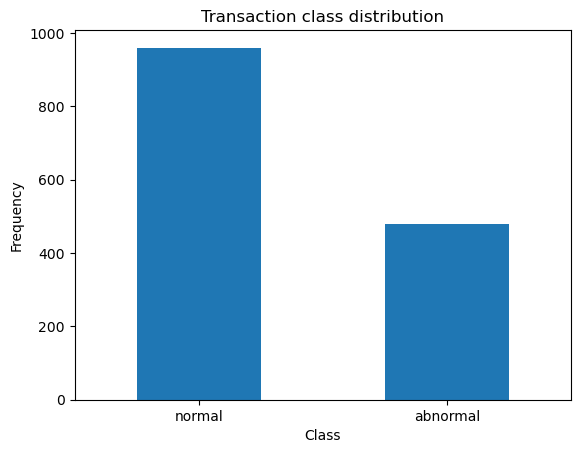

In [22]:
LABELS = ["normal", "abnormal"]

count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [24]:
abnormal = df[df.Class == 1]
normal = df[df.Class == 0]

In [28]:
RANDOM_SEED = 42

X_train, X_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

X_train.shape

(765, 270)

In [40]:
# 노이즈 추가
noise_factor = 0.2
noisy_X_train = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
noisy_X_train = np.clip(noisy_X_train, 0.0, 1.0)  # 데이터 범위를 클리핑합니다.

In [42]:
# Denoising Autoencoder 모델 정의
input_dim = X_train.shape[1]
encoding_dim = 14  # 인코딩 차원 설정

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

denoising_autoencoder = Model(inputs=input_layer, outputs=decoded)
denoising_autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# 모델 학습
history = denoising_autoencoder.fit(noisy_X_train, X_train, 
                                     epochs=50, 
                                     batch_size=256, 
                                     shuffle=True, 
                                     validation_split=0.1)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 5.7437 - val_loss: 5.7039
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.7260 - val_loss: 5.6946
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.7233 - val_loss: 5.6832
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.7793 - val_loss: 5.6689
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.7406 - val_loss: 5.6513
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.7382 - val_loss: 5.6298
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.6928 - val_loss: 5.6045
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.6734 - val_loss: 5.5750
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.6303 - val_loss: 5.5415
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.5982 - val_loss: 5.5042
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.5619 - val_loss: 5.4638
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.5245 - val_loss: 5.4214
Epoch 13/50


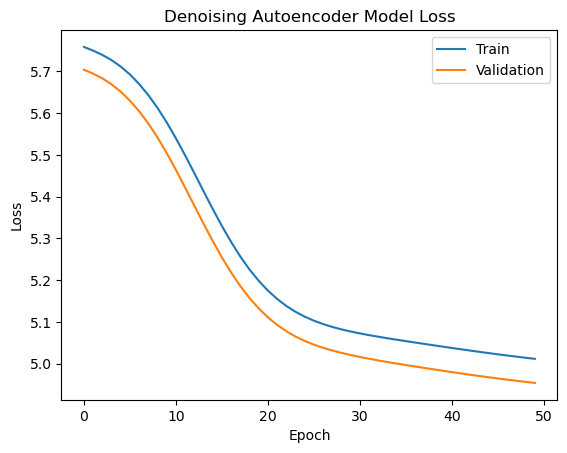

In [44]:
# 손실 그래프 그리기
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Denoising Autoencoder Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [48]:
# 테스트 데이터에서 복원 오차 계산
predictions = denoising_autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step


In [52]:
# 결과 출력
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,288.000000,288.000000
mean,167.454518,0.322917
std,325.421365,0.468405
min,4.523680,0.000000
25%,4.741686,0.000000
50%,5.182436,0.000000
75%,125.984941,1.000000
max,1734.142567,1.000000


In [54]:
error_df.head()

,reconstruction_error,true_class
168,5.154725,0
605,5.153475,0
548,5.366533,0
65,5.747259,0
628,5.150669,0


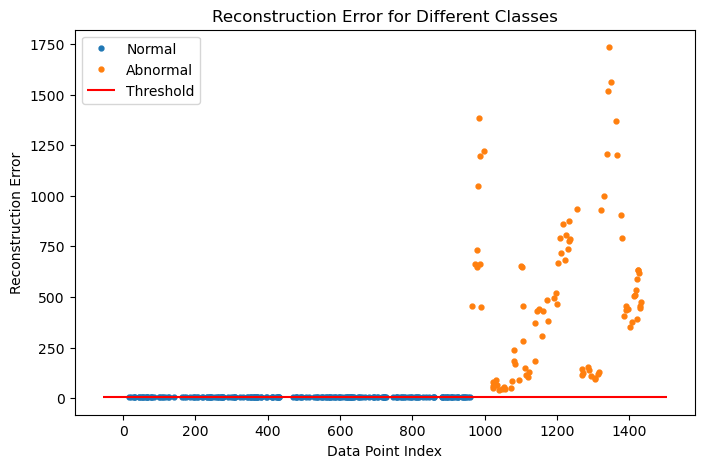

In [64]:
threshold = 5

# 클래스별 그룹화
groups = error_df.groupby('true_class')

fig, ax = plt.subplots(figsize=(8, 5))

for name, group in groups:
    # 클래스별 인덱스 재설정
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label="Abnormal" if name == 1 else "Normal")
    
# Threshold 라인 추가
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')

# 레전드 및 타이틀 설정
ax.legend()
plt.title("Reconstruction Error for Different Classes")
plt.ylabel("Reconstruction Error")
plt.xlabel("Data Point Index")
plt.show()


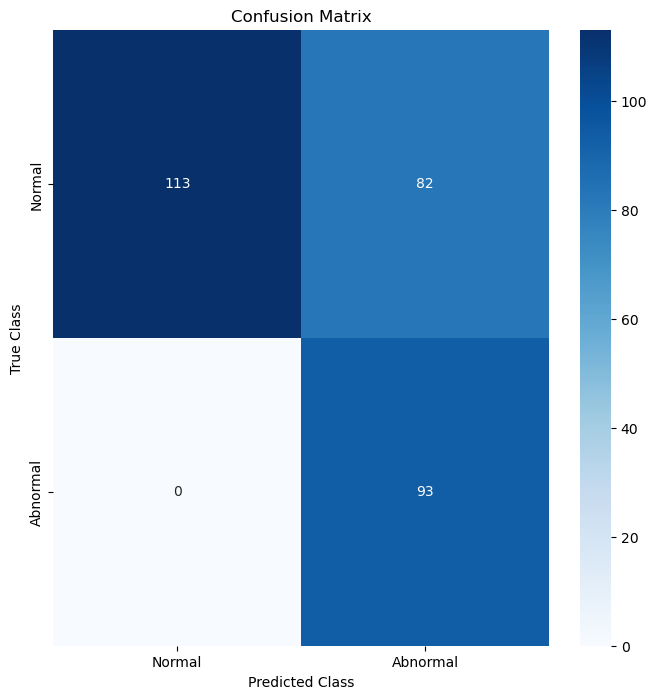

              precision    recall  f1-score   support

           0       1.00      0.58      0.73       195
           1       0.53      1.00      0.69        93

    accuracy                           0.72       288
   macro avg       0.77      0.79      0.71       288
weighted avg       0.85      0.72      0.72       288



In [66]:
# 혼동 행렬 및 성능 평가
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.title("Confusion Matrix")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

print(classification_report(error_df.true_class, y_pred))